## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os
import os.path as osp
import sys

BASE = os.path.dirname(os.path.abspath(os.path.dirname("file"))) # latent_3D
sys.path.append(BASE)  # latent_3D
print(BASE)

from src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from src.autoencoder import Configuration as Conf
from src.point_net_ae import PointNetAutoEncoder

from src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from src.tf_utils import reset_tf_graph
from src.general_utils import plot_3d_point_cloud

/home/sohee/coding/PointCloud/lgan/latent_3d_points
Instructions for updating:
Colocations handled automatically by placer.
Success


In [2]:
# # -*- coding: utf-8 -*-
# import numpy as np
# import os
# import os.path as osp
# import sys
# import matplotlib.pylab as plt

# BASE = os.path.dirname(os.path.abspath(os.path.dirname("file"))) # latent_3D
# sys.path.append(BASE) 

# from src.point_net_ae import PointNetAutoEncoder
# from src.autoencoder import Configuration as Conf
# from src.neural_net import MODEL_SAVER_ID

# from src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
#                                         load_all_point_clouds_under_folder

# from src.general_utils import plot_3d_point_cloud
# from src.tf_utils import reset_tf_graph

# from src.vanilla_gan import Vanilla_GAN
# from src.w_gan_gp import W_GAN_GP
# from src.generators_discriminators import latent_code_discriminator_two_layers,\
# latent_code_generator_two_layers


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [3]:
class_name = 'sofa'
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'

top_out_dir = 'log/pointnet'          # Use to save Neural-Net check-points etc.
top_in_dir = 'data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

top_out_dir = osp.join(BASE, top_out_dir, class_name)
top_in_dir = osp.join(BASE, top_in_dir)


load_pre_trained_ae = False
#True #False
restore_epoch = 1000

experiment_name = 'single_class_ae_' + ae_loss 
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size

#class_name = input('Give me the class name (e.g. "chair"): ').lower()

In [4]:
# train_params = default_train_params()
train_params = {'batch_size': 50, 
                'training_epochs': 500,
                'denoising': False,
                'learning_rate': 0.0005,
                'z_rotate': False,
                'saver_step': 10,
                'loss_display_step': 1
               }

Load Point-Clouds

In [5]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

3173 pclouds were loaded. They belong in 1 shape-classes.


Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [6]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [8]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

If you ran the above lines, you can reload a saved model like this:

In [10]:
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)
else :
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)

[None, 2048, 3]
Building Encoder
encoder_conv_layer_0 conv params =  256
bnorm params =  128
Tensor("single_class_ae_chamfer_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320
bnorm params =  256
Tensor("single_class_ae_chamfer_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512
bnorm params =  256
Tensor("single_class_ae_chamfer_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024
bnorm params =  512
Tensor("single_class_ae_chamfer_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896
bnorm params =  256
Tensor("single_class_ae_chamfer_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_chamfer_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024
Tensor("single_class_

Build AE Model.

In [27]:
# reset_tf_graph()
# ae = PointNetAutoEncoder(conf.experiment_name, conf)

Train the AE (save output to train_stats.txt) 

In [28]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

Epoch: 1001 	 training time =  0: 0: 6 	 loss = 0.000440624
Epoch: 1002 	 training time =  0: 0: 5 	 loss = 0.000434652
Epoch: 1003 	 training time =  0: 0: 5 	 loss = 0.000441274
Epoch: 1004 	 training time =  0: 0: 5 	 loss = 0.000435529
Epoch: 1005 	 training time =  0: 0: 5 	 loss = 0.000433491
Epoch: 1006 	 training time =  0: 0: 5 	 loss = 0.000443296
Epoch: 1007 	 training time =  0: 0: 5 	 loss = 0.000437980
Epoch: 1008 	 training time =  0: 0: 5 	 loss = 0.000438975
Epoch: 1009 	 training time =  0: 0: 5 	 loss = 0.000436841
Epoch: 1010 	 training time =  0: 0: 5 	 loss = 0.000440001
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer/models.ckpt-1010 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 1011 	 training time =  0: 0: 5 	 loss = 0.000438960
Epoch: 1012 	 training time =  0: 0: 5 	 loss = 0.000438424
Epoch: 1013 	 training time =  0: 0: 5 	 loss = 0.000436315
Epoch: 1014 	 training time =  0: 0: 5 	 l

Epoch: 1108 	 training time =  0: 0: 5 	 loss = 0.000434051
Epoch: 1109 	 training time =  0: 0: 5 	 loss = 0.000431991
Epoch: 1110 	 training time =  0: 0: 5 	 loss = 0.000436984
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer/models.ckpt-1110 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 1111 	 training time =  0: 0: 5 	 loss = 0.000433055
Epoch: 1112 	 training time =  0: 0: 5 	 loss = 0.000440071
Epoch: 1113 	 training time =  0: 0: 5 	 loss = 0.000434932
Epoch: 1114 	 training time =  0: 0: 5 	 loss = 0.000437648
Epoch: 1115 	 training time =  0: 0: 5 	 loss = 0.000434421
Epoch: 1116 	 training time =  0: 0: 5 	 loss = 0.000434298
Epoch: 1117 	 training time =  0: 0: 5 	 loss = 0.000432691
Epoch: 1118 	 training time =  0: 0: 5 	 loss = 0.000431971
Epoch: 1119 	 training time =  0: 0: 5 	 loss = 0.000433553
Epoch: 1120 	 training time =  0: 0: 5 	 loss = 0.000435522
INFO:tensorflow:/home/sohee/coding/PointCl

Epoch: 1212 	 training time =  0: 0: 5 	 loss = 0.000433269
Epoch: 1213 	 training time =  0: 0: 5 	 loss = 0.000436412
Epoch: 1214 	 training time =  0: 0: 5 	 loss = 0.000428830
Epoch: 1215 	 training time =  0: 0: 5 	 loss = 0.000431464
Epoch: 1216 	 training time =  0: 0: 5 	 loss = 0.000429942
Epoch: 1217 	 training time =  0: 0: 5 	 loss = 0.000439541
Epoch: 1218 	 training time =  0: 0: 5 	 loss = 0.000431520
Epoch: 1219 	 training time =  0: 0: 5 	 loss = 0.000431398
Epoch: 1220 	 training time =  0: 0: 5 	 loss = 0.000434248
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer/models.ckpt-1220 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 1221 	 training time =  0: 0: 5 	 loss = 0.000427319
Epoch: 1222 	 training time =  0: 0: 5 	 loss = 0.000429047
Epoch: 1223 	 training time =  0: 0: 5 	 loss = 0.000429901
Epoch: 1224 	 training time =  0: 0: 5 	 loss = 0.000435383
Epoch: 1225 	 training time =  0: 0: 5 	 l

Epoch: 1319 	 training time =  0: 0: 5 	 loss = 0.000429275
Epoch: 1320 	 training time =  0: 0: 5 	 loss = 0.000428010
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer/models.ckpt-1320 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 1321 	 training time =  0: 0: 5 	 loss = 0.000430978
Epoch: 1322 	 training time =  0: 0: 5 	 loss = 0.000427882
Epoch: 1323 	 training time =  0: 0: 5 	 loss = 0.000429085
Epoch: 1324 	 training time =  0: 0: 5 	 loss = 0.000430713
Epoch: 1325 	 training time =  0: 0: 5 	 loss = 0.000428347
Epoch: 1326 	 training time =  0: 0: 5 	 loss = 0.000427245
Epoch: 1327 	 training time =  0: 0: 5 	 loss = 0.000429574
Epoch: 1328 	 training time =  0: 0: 5 	 loss = 0.000427152
Epoch: 1329 	 training time =  0: 0: 5 	 loss = 0.000431303
Epoch: 1330 	 training time =  0: 0: 5 	 loss = 0.000427926
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer

Epoch: 1423 	 training time =  0: 0: 5 	 loss = 0.000428532
Epoch: 1424 	 training time =  0: 0: 5 	 loss = 0.000426988
Epoch: 1425 	 training time =  0: 0: 5 	 loss = 0.000425516
Epoch: 1426 	 training time =  0: 0: 5 	 loss = 0.000425623
Epoch: 1427 	 training time =  0: 0: 5 	 loss = 0.000427058
Epoch: 1428 	 training time =  0: 0: 5 	 loss = 0.000426109
Epoch: 1429 	 training time =  0: 0: 5 	 loss = 0.000427653
Epoch: 1430 	 training time =  0: 0: 5 	 loss = 0.000430658
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer/models.ckpt-1430 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 1431 	 training time =  0: 0: 5 	 loss = 0.000426304
Epoch: 1432 	 training time =  0: 0: 5 	 loss = 0.000425252
Epoch: 1433 	 training time =  0: 0: 5 	 loss = 0.000430613
Epoch: 1434 	 training time =  0: 0: 5 	 loss = 0.000426291
Epoch: 1435 	 training time =  0: 0: 5 	 loss = 0.000425113
Epoch: 1436 	 training time =  0: 0: 5 	 l

In [29]:
print(len(train_stats))

500


/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer


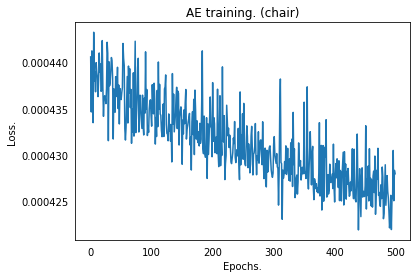

In [30]:
plot_train_curve = True
import matplotlib.pylab as plt

print(conf.train_dir) # ../data/single_class_ae

if plot_train_curve:
    x = range(len(train_stats))
    loss = [t[1] for t in train_stats] # [0] epoch  [1] loss  [2] time

    plt.plot(x, loss)
    plt.title('AE training. (%s)' %(class_name))
    
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.tick_params(axis='y', which='both', left=False, right=False)
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')

In [31]:
how_long_time = True


if how_long_time:
    time = [t[2] for t in train_stats] 
total = sum(time)  
m, s = divmod(total, 60)
h, m = divmod(m, 60)

print('Total runtime : %2d:%2d:%2d / %d epoch' %(h, m, s, len(time)))

Total runtime :  0:47: 1 / 500 epoch


Get a batch of reconstuctions and their latent-codes.

In [32]:
# num = all_pc_data.num_examples
# print(num)

# feed_pc, feed_model_names, _ = all_pc_data.next_batch(num)
# reconstructions = ae.reconstruct(feed_pc)[0]
# latent_codes = ae.transform(feed_pc)

Use any plotting mechanism such as matplotlib to visualize the results.

In [33]:
# i = 2
# plot_3d_point_cloud(reconstructions[i][:, 0], 
#                     reconstructions[i][:, 1], 
#                     reconstructions[i][:, 2], in_u_sphere=True);

# i = 4
# plot_3d_point_cloud(reconstructions[i][:, 0], 
#                     reconstructions[i][:, 1], 
#                     reconstructions[i][:, 2], in_u_sphere=True);

Save

In [34]:
# import numpy as np
# import pandas as pd
# import os           
# import tensorflow as tf

# def createDir(dirname, path=os.getcwd()):
#     dirpath = osp.join(path, dirname)
#     try:
#         os.mkdir(dirpath)
#     except OSError as error:
#         print ("exist")
        
# # os.makedirs(osp.join(conf.train_dir, 'ae_npy'))
# # os.makedirs(osp.join(conf.train_dir, 'ae_txt'))

# createDir('ae_npy', conf.train_dir)
# createDir('ae_txt', conf.train_dir)

# # np.savez(osp.join(conf.train_dir, 'ae_npy', 'ae_reconstructions.npz'), reconstructions)
# np.save(osp.join(conf.train_dir, 'ae_npy', 'ae.npy'), reconstructions)      

In [35]:
# f = open(osp.join(conf.train_dir, 'ae_reconstruction.txt'), 'a')
# f.write(reconstructions)
# f.close()

In [36]:
    
# for i in range(0,num):
#     xx = reconstructions[i][:, 0]
#     x = xx.tolist()
#     #     x = tf.convert_to_tensor(xx, dtype = tf.float32)
    
#     yy = reconstructions[i][:, 1]
#     y = yy.tolist()
#     zz = reconstructions[i][:, 2]
#     z = zz.tolist()
    
#     np.save(osp.join(conf.train_dir, 'ae_npy', 'ae_recon_'+ str(i).zfill(5) +'.npy'), reconstructions[i])
    
    
      
#     p = open(osp.join(conf.train_dir, 'ae_txt', 'ae_recon_'+ str(i).zfill(5) +'.txt'), 'w+')
#     for k in range(0,2048):          
#         p.write('%8f\t%8f\t%8f\n' %(x[k], y[k], z[k]))
#     p.close()